# Cal-Adapt Analytics Engine: Threshold Tools Basics

In this notebook, return values, probabilities, and periods can be inferred from extreme weather events identified as the events with the maximum value in a year (e.g. the hottest hour in a year). To examine the changing frequency of events above or below a specific threshold value (e.g. critical value for infrastructure), please see the *threshold_exceedance.ipynb* notebook. Development to use return value, probability, and return period calculation tools with threshold values instead of maximum values is currently ongoing.

**Intended application**: As a user, I want to understand <span style="color:#FF0000">**how to characterize extreme weather events**</span> by:
1. Calculating the return values, periods, and probabilities of a region of interest
2. Visualize the spatial distribution of return values, periods, and probabilities across a region of interest

**Terms used in this notebook**:
- __return values__ (e.g., the value of a high temperature that will be reached once every 10 years, i.e., the value of a high temperature event with a 10-year return period)
- __return probabilities__ (e.g., the probability of temperature exceeding 300 Kelvin)
- __return periods__ (e.g., how often, on average, a 300 Kelvin monthly average temperature event will occur; how often, on average, a 150 mm daily precipitation event will occur)

The techniques in this notebook come from applications of extreme value theory to climate data. For further reading on this topic, see [Cooley 2009](https://link.springer.com/article/10.1007/s10584-009-9627-x).

**Runtime**: With the default settings, this notebook takes approximately **50-55 minutes** to run from start to finish. Modifications to selections may increase the runtime. 

## Step 0: Setup
Import necessary packages before running analysis

In [1]:
import xarray as xr

import climakitae as ck
import climakitaegui as ckg
from climakitae.explore import threshold_tools
from climakitaegui.explore import threshold_tools as threshold_tools_gui

## Step 1: Select and retrieve data of interest
### 1a) Select data
In the code cell below, the `ck.Select()` function of the `climakitae` app displays an interface for data selection. The selected data will be used to calculate return values, probabilities, and periods. To perform the example analyses provided later in the notebook, we recommend using the defaults, except subset the data by the state of California (CA).

<span style="color:red"><b>Warning:</b></span> Ensure that you __don't__ compute an area average across grid cells within your selected region by setting the area average option to **No**.

__Note:__
- This version only offers the [dynamically-downscaled](https://dept.atmos.ucla.edu/alexhall/downscaling-cmip6) data.
- If you select 'daily' for 'Timescale', it will result in a daily aggregation of the hourly data. If you select 'monthly' for 'Timescale', it will result in a monthly aggregation of the daily data. The aggregation can be average, maximum, or sum as appropriate for the data variable.

__Tip:__ When performing your own analysis with __Future Model Data__, select just one scenario to help streamline the analysis.

Row
    [0] Card(collapsible=False, height=775, sizing_mode='fixed', styles={'header_background': 'lig...}, title='Data Options i..., width=635)
        [0] Column
            [0] Row
                [0] Column(width=200)
                    [0] StaticText(name='Data Type')
                    [1] RadioBoxGroup(options=OrderedDict({'Gridded': 'G...]), value='Gridded')
                [1] Column(width=200)
                    [0] StaticText(name='Approach')
                    [1] RadioBoxGroup(options=OrderedDict({'Time': 'Time...]), value='Time')
                [2] Column(width=200)
                    [0] StaticText(name='Downscaling Method')
                    [1] RadioBoxGroup(name='Downscaling method', options=OrderedDict({'Dynamical': ...]), value='Dynamical')
        [1] Divider(margin=(-10, 0, 0, 0))
        [2] Row
            [0] Column(width=300)
                [0] StaticText(name='Variable Type')
                [1] RadioBoxGroup(inline=True, options=OrderedDict({'Variable': '...]), value='Variable')
                [2] Select(options=OrderedDict({'Air Temperat...]), value='Air Temperature at 2m', width=225)
                [3] StaticText(value='Temperature o...)
            [1] Column
                [0] Row
                    [0] Column(width=100)
                        [0] StaticText(name='Variable Units')
                        [1] RadioBoxGroup(name='Units', options=OrderedDict({'K': 'K', ...]), value='K')
                    [1] Column(width=100)
                        [0] StaticText(name='Timescale')
                        [1] RadioBoxGroup(options=OrderedDict({'daily': 'dai...]), value='monthly')
                    [2] Column(width=100)
                        [0] StaticText(name='Model Grid-Spacing')
                        [1] RadioBoxGroup(name='Resolution', options=OrderedDict({'3 km': '3 km...]), value='45 km')
                [1] Column(width=300)
                    [0] StaticText(styles={'color': 'red'})
        [3] Divider(margin=(-10, 0, 0, 0))
        [4] Column
            [0] StaticText(name='WARMING LEVELS APPROACH', value='Options only v...)
            [1] Row
                [0] Column(width=270)
                    [0] StaticText(name='Years around G..., value='e.g. 15 means a...)
                    [1] IntSlider(end=25, start=5, value=15, width=240)
                [1] Column(width=250)
                    [0] StaticText(name='Warming Level (°C)')
                    [1] CheckBoxGroup(inline=True, options=OrderedDict({'n/a': '...]), value=['n/a'])
        [5] Divider(margin=(-10, 0, 0, 0))
        [6] Column
            [0] StaticText(name='TIME-BASED APPROACH', value='Options only v...)
            [1] Row
                [0] Column(width=300)
                    [0] StaticText(name='Years', value='How do you want t...)
                    [1] RangeSlider(end=2100, start=1950, step=1, value=(1980, 2015), value_end=2015, value_start=1980, width=250)
                    [2] StaticText(name='Historical Data', value='<br>Estimates o...)
                    [3] CheckBoxGroup(name='Scenario historical', options=OrderedDict({'Historical C...]), value=['Historical Climate'])
                    [4] StaticText(name='Future Model Data', value='<br> Shared S...)
                    [5] CheckBoxGroup(name='Scenario ssp', options=OrderedDict({'SSP 2-4.5': ...]))
                [1] Column(width=300)
                    [0] ParamMethod(method, _pane=Matplotlib, defer_load=False)
                    [1] StaticText(styles={'color': 'red'})
    [1] Card(collapsible=False, height=775, sizing_mode='fixed', styles={'header_background': 'lig...}, title='Location Options f..., width=635)
        [0] Row
            [0] Column(width=310)
                [0] ParamMethod(method, _pane=Matplotlib, defer_load=False)
                [1] Select(name='Subset the data by...', options=OrderedDict({'none': 'none...]), value='states', width=225)
                [2] MultiSelect(name='Location selection', options
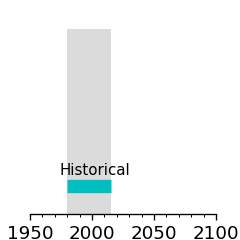
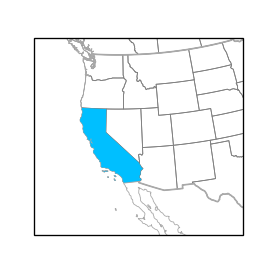

In [2]:
selections = ckg.Select()
selections.area_subset = 'states'
selections.cached_area = ['CA']
selections.resolution = '45 km'
selections.show()

### 1b) Retrieve data

The next cell may take several minutes to run, as there is a lot of data being retrieved. Hang tight!

In [3]:
generated_data = selections.retrieve()

<a id='transform'></a>
## Step 2: Transform data to prepare for calculations

### 2a) Subset data by scenario and simulation to prepare it for `threshold_tools` functions

Currently, the `threshold_tools` functions that perform the calculations require an input where there is only one scenario and one simulation selected. In the cell below, we select 'Historical Climate' as the scenario, and 'WRF-CNRM-ESM2-1_r1ip1f2' as the simulation, but you can replace `scenario` and `simulation` with different selections (viewable in `generated_data` above!).

In [4]:
subsetted_data = generated_data.sel(scenario='Historical Climate').sel(simulation='WRF_CNRM-ESM2-1_r1i1p1f2')
subsetted_data

<xarray.DataArray 'Air Temperature at 2m' (time: 408, y: 28, x: 12)> Size: 548kB
dask.array<getitem, shape=(408, 28, 12), dtype=float32, chunksize=(408, 28, 12), chunktype=numpy.ndarray>
Coordinates:
    lakemask           (y, x) float32 1kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 1kB 0.0 0.0 0.0 1.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 1kB 31.32 31.55 31.78 ... 42.82 43.07
    lon                (y, x) float32 1kB -117.9 -117.5 -117.1 ... -121.9 -121.4
  * time               (time) datetime64[ns] 3kB 1980-09-01 ... 2014-08-01
  * x                  (x) float64 96B -4.26e+06 -4.215e+06 ... -3.765e+06
  * y                  (y) float64 224B 5.839e+05 6.289e+05 ... 1.799e+06
    Lambert_Conformal  int64 8B 0
    simulation         <U26 104B 'WRF_CNRM-ESM2-1_r1i1p1f2'
    scenario           <U18 72B 'Historical Climate'
Attributes:
    variable_id:           t2
    extended_description:  Temperature of the air 2m above Earth's surface. T...
    units:                 K
    data_type:             Gridded
    resolution:            45 km
    frequency:             monthly
    location_subset:       ['CA']
    approach:              Time
    downscaling_method:    Dynamical
    institution:           UCLA
    grid_mapping:          Lambert_Conformal

### Step 2b) Calculate Annual Maximum Series (AMS) for all grid cells

This is the first step of extreme value analysis -- identifying what conditions are extreme. We default to considering each annual maximum value as a sample of an extreme event. Here, extreme events are evaluated using the annual block maxima approach, which determines the maximum value within a given block period (year). Because this approach considers only the maximum, it is limited when multiple extremes occur in a single year, since some of the extremes (that may be more extreme than the maxima in subsequent years) are excluded. This limitation makes the tools in this notebook not ideal for California in cases such as atmospheric river events or evaluating extreme wet and dry years. 

After calculating the AMS, run `ck.load` to bring the data down to an appropriate size for later computations - this step may take several minutes. 

In [7]:
ams = threshold_tools.get_block_maxima(ck.load(subsetted_data), extremes_type='max', check_ess=False)
ams = ck.load(ams)
ams

Processing data to read 535.50 KB of data into memory... Complete!
Dropping <xarray.DataArray 'Air Temperature at 2m' ()> Size: 8B
array(5005)
Coordinates:
    Lambert_Conformal  int64 8B 0
    simulation         <U26 104B 'WRF_CNRM-ESM2-1_r1i1p1f2'
    scenario           <U18 72B 'Historical Climate'
Attributes: (12/18)
    variable_id:                      t2
    extended_description:             Temperature of the air 2m above Earth's...
    units:                            K
    data_type:                        Gridded
    resolution:                       45 km
    frequency:                        monthly
    ...                               ...
    duration:                         None
    groupby:                          None
    grouped_duration:                 None
    extreme_value_extraction_method:  block maxima
    block_size:                       1 year
    timeseries_type:                  block max series block maxima NaNs for Air Temperature at 2m. Please guida

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


<xarray.DataArray 'Air Temperature at 2m' (time: 0, y: 28, x: 12)> Size: 0B
array([], shape=(0, 28, 12), dtype=float32)
Coordinates:
    lakemask           (y, x) float32 1kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 1kB 0.0 0.0 0.0 1.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 1kB 31.32 31.55 31.78 ... 42.82 43.07
    lon                (y, x) float32 1kB -117.9 -117.5 -117.1 ... -121.9 -121.4
  * x                  (x) float64 96B -4.26e+06 -4.215e+06 ... -3.765e+06
  * y                  (y) float64 224B 5.839e+05 6.289e+05 ... 1.799e+06
    Lambert_Conformal  int64 8B 0
    simulation         <U26 104B 'WRF_CNRM-ESM2-1_r1i1p1f2'
    scenario           <U18 72B 'Historical Climate'
  * time               (time) datetime64[ns] 0B 
Attributes: (12/18)
    variable_id:                      t2
    extended_description:             Temperature of the air 2m above Earth's...
    units:                            K
    data_type:                        Gridded
    resolution:                       45 km
    frequency:                        monthly
    ...                               ...
    duration:                         None
    groupby:                          None
    grouped_duration:                 None
    extreme_value_extraction_method:  block maxima
    block_size:                       1 year
    timeseries_type:                  block max series

## Step 3: Calculate values of interest
### 3a) Find a distribution to use for calculation
Calculating return values, probabilities, and periods requires [fitting a probability distribution](https://en.wikipedia.org/wiki/Probability_distribution_fitting) to the annual maximum data values computed in Step 2. Step 3a) contains tools for finding a distribution that fits the data well. You can select among a list of distributions and evaluate how well a selected distribution fits the annual maximum data values. The evaluation is conducted through a goodness of fit statistical test. You can also visualize the test results on a map.

**Test goodness of fit of selected distribution**
The `get_ks_stat` function of `threshold_tools` performs the [KS goodness of fit test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). The test can be used to evaluate the fit between data and a reference probability distribution. Specifically, the function tests the null hypothesis that the input data are distributed according to the selected distribution. The alternative hypothesis is that the data are _not_ distributed according to the distribution. The function outputs p-values from the tests. At the confidence level of 95%, the null hypothesis should be rejected in favor of the alternative if the p-value is less than the critical value of 0.05, suggesting that the selected distribution _doesn't_ fit the data well.

The cell below performs the KS test on the AMS data with the generalized extreme value (GEV) distribution as the reference distribution.

Below is a full list of reference distributions that can be specified in the `distr=` part the `get_ks_stat` function, along with information on the situations in which each distribution is often used.

- __gev__ - Generalized extreme value (GEV) distribution - allows for a continuous range of different shapes, and will reduce to the Gumbel, Weibull, and Generalized Pareto distributions under different conditions. The GEV distribution may generally provide a better fit than the three individual distributions, and is a common distribution used in hydrological applications.
- __gumbel__ - Gumbel distribution - Range of interest is unlimited
- __weibull__ - Weibull distribution - Range of interest has an upper limit
- __pearson3__ - Pearson Type III distribution - Range of interest has a lower limit
- __genpareto__ - Generalized Pareto distribution - This distribution is often used in application for river flood events and suggested to be of a good general fit for precipitation in the United States.

In [8]:
goodness_of_fit = threshold_tools.get_ks_stat(ams, distr='gev', multiple_points=True)
goodness_of_fit

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

Evaluate the p-values in the `goodness_of_fit` data to ensure the selected distribution fits the data well. Once you have identified a distribution with satisfactory goodness of fit, please proceed to Step 3b) to calculate return values, probabilities, and/or periods.

**Visualize goodness of fit test results**

Observe a geospatial map of p-values from the KS test to ensure the selected distribution fits the data well. The p-values should be above the critical value associated with your desired level of confidence. We default to a p-value of 0.05, or the 95% confidence level.

In [9]:
threshold_tools_gui.get_geospatial_plot(goodness_of_fit, data_variable='p_value')

NameError: name 'goodness_of_fit' is not defined

### 3b) Calculate values of interest using a distribution that fits the data well

**Calculate return value for a selected return period**
The `get_return_value` function in `threshold_tools` calculates the return value for a certain return period (i.e., 1-in-X-year event). Confidence intervals of the return values can also be calculated. The cell below calculates the return value for a 1-in-10-year extreme high monthly average temperature event. The return values are inferred from GEV distributions fitted to the AMS. A hundred bootstrap samples are also used to calculate 95% confidence intervals.

To perform your own analysis, specify `distr=` as the distribution you found in Step 3a), and `return_period=` as the return period of your interest (in years). You may also specify a different number of bootstrap samples used to calculate confidence intervals, as well as different lower and upper bounds of the confidence intervals. 

__Tip:__ `bootstrap_runs`, `conf_int_lower_bound`, and `conf_int_upper_bound` are set to the default values in the example. If you want to perform the analysis with these default values, you don't need to specify them explicitly. For instance, the example code is equivalent to `threshold_tools.get_return_value(ams, return_period=10, distr='gev', multiple_points=True)`

**Note:** Since we're running 100 bootstraps, this cell will take a while (~20 min.)!

In [10]:
%%time
return_value = threshold_tools.get_return_value(
    ams, return_period=10, distr='gev',
    bootstrap_runs=100,
    conf_int_lower_bound=2.5,
    conf_int_upper_bound=97.5,
    multiple_points=True
)
return_value

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

#### 3c) Calculate return probability of exceedance of selected threshold

The `get_return_prob` function in `threshold_tools` calculates the probability of a variable exceeding a certain threshold. Confidence intervals of the return probabilities can also be calculated. The cell below calculates the probability of monthly average temperature exceeding 300 Kelvin. The return probabilities are inferred from Pearson Type III distributions fitted to the AMS. By default, a hundred bootstrap samples are also used to calculate 95% confidence intervals.

To perform your own analysis, specify `distr=` as the distribution you found in Step 3a), and `threshold=` as the threshold of your interest. The unit of the threshold is assumed to be the same as that of the data variable in the AMS. You may also specify the number of bootstrap samples (using `bootstrap_runs=`), as well as the lower and upper bounds of the confidence intervals (using `conf_int_lower_bound=` and `conf_int_upper_bound=`).

**Note:** Similarly here, we're also running 100 bootstraps in the backend to get the return probability from a bootstrapped distribution. This will take less time (~10 min.).

In [ ]:
%%time
return_prob = threshold_tools.get_return_prob(ams, threshold=300, distr='pearson3', multiple_points=True)
return_prob

#### 3d) Calculate return period for a selected return value

The `get_return_period` function in `threshold_tools` calculates the return period (i.e., 1-in-X-year) for a certain return value. Confidence intervals of the return periods can also be calculated.

The example code calculates the return period of 300 Kelvin events. The return periods are inferred from Weibull distributions fitted to the AMS. By default, a hundred bootstrap samples are also used to calculate 95% confidence intervals.

**Note:** Same note as above for `pearson3`. This will take ~10 min.

In [ ]:
%%time
return_period = threshold_tools.get_return_period(ams, return_value=300, distr='weibull', multiple_points=True)
return_period

## Step 4: Visualize values of interest

In the next 3 cells we'll visualize our results, starting with the return value:

In [ ]:
threshold_tools_gui.get_geospatial_plot(return_value, data_variable='return_value')

Next, return probabilities:

In [ ]:
threshold_tools_gui.get_geospatial_plot(return_prob, data_variable='return_prob')

Lastly, return periods:

In [ ]:
threshold_tools_gui.get_geospatial_plot(return_period, data_variable='return_period', bar_max=1000)

<a id='export'></a>
## Step 5: Export results

To save data as a file, call `export` and input your desired
1) data to export – an [xarray DataArray or Dataset](https://docs.xarray.dev/en/stable/user-guide/data-structures.html), as output by e.g. selections.retrieve()
2) output file name (without file extension)
3) file format ("NetCDF" or "CSV")

As an example, the next cell exports `return_period` to a NetCDF file named "my_filename_1".

In [ ]:
ck.export(return_period, "my_filename_1", "NetCDF")

You may also export only one of the variables in an xarray Dataset. For example:

In [ ]:
variable = "return_period"
return_period_variable = return_period[variable]

In [ ]:
ck.export(return_period_variable, "my_filename_2", "CSV")